# Mapping

This notebook uses the cartopy package to generate maps of data variables of interest in the Arctic.

 
**Input**:
 - NETCDF4 file from the jupyter book's google bucket
 
 
 **Output**: 
  - Maps of sea ice thickness and sea ice type in the Arctic

```{tip}
Try running this notebook in Google Colab! Toggle over the rocketship icon at the top of the page and click Colab to open a new window and run the notebook. <br><br>To run a single cell, type **Shift+Enter**. To run the whole notebook, under **Runtime** click **Run all**. Note that you will have to run the notebook from the very beginning and load all the Google Colab dependencies for the code to work.
```

In [1]:
#this cell will load dependencies for running the notebook in Google Colab
#this cell may take a while to run
import sys

#if code is running in google colab, run these cells to install neccessary libraries
if 'google.colab' in sys.modules: 
    !apt-get install -qq libgdal-dev libproj-dev
    !pip install --no-binary shapely shapely --force
    !pip install -q pyproj
    !pip install cartopy
    !pip install netcdf4
    !pip install xarray==0.16.0 

## Import notebook dependencies

In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import numpy.ma as ma
import scipy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pyproj
from datetime import date

#axes needed for plotting
from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
GeoAxes._pcolormesh_patched = Axes.pcolormesh

# Ignore warnings in the notebook to improve display
# You might want to remove this when debugging/writing new code
import warnings
warnings.filterwarnings('ignore')

#increase resolution for notebook outputs
%matplotlib inline 
%config InlineBackend.figure_format = 'retina' 

#import utils function 
if 'utils.py' not in os.listdir(os.getcwd()): 
    !gsutil cp gs://icesat2-book-data/utils.py ./
import utils

## Load data into notebook
Copy file from the book's google bucket and load into an xarray dataset. 

In [3]:
!gsutil cp gs://icesat2-book-data/icesat2-book-winter-data.nc ./
dataset = xr.open_dataset('icesat2-book-winter-data.nc')

Copying gs://icesat2-book-data/icesat2-book-winter-data.nc...
/ [1 files][144.7 MiB/144.7 MiB]                                                
Operation completed over 1 objects/144.7 MiB.                                    


## Restrict dataset to region of interest

In [4]:
#myKeys = [10,11,12,13,15] #Inner Arctic
#dataset = utils.restrictRegionally(dataset, regionKeyList = myKeys)

## Plot one month of data 

```{note}
Cartopy has a bug and cannot produce a contour plot on a rotated grid. Here we use a workaround from stackexchange: [https://stackoverflow.com/questions/55062406/cartopy-fails-to-correctly-contour-data-on-rotated-grid](https://stackoverflow.com/questions/55062406/cartopy-fails-to-correctly-contour-data-on-rotated-grid)
```

Define function

In [5]:
def plotOneMonth(dataset, dataVar, month, minval, maxval, cbarTicks = None, cmap = 'viridis'): 
    """Plots map of the arctic on North Pole Stereo projection with one month of data overlayed, along with the sea ice edge for each month.
   
    Args:
        dataset (xr Dataset): dataset from google bucket
        dataVar (str): variable of interest
        month (str): month and year of interest, i.e. 'Dec 2019' (does not need to be in any particular format)
        minval, maxval (int): minimum and maximum values for the data variable 
        cbarTicks (list or np array of length 2): ticks to use on colorbar (default to [minval + 1, maxval +1])
        cmap (str, optional): color map (default to viridis)
        
    Returns:
        Figure displayed in notebook 
    
    """
    
    #define projection and transform
    proj = ccrs.NorthPolarStereo(central_longitude = -45)
    transform = ccrs.PlateCarree()
    
    #initialize the figure and axes 
    plt.figure(figsize=(6, 6))
    ax = plt.axes(projection = proj)
    
    #define arguments if not inputted 
    cbarTicks = np.arange(minval, maxval + 1, 1) if cbarTicks is None else cbarTicks
    
    #plot sea ice concentraion 
    SICarray = dataset['seaice_conc_monthly_cdr'].sel(time = month).where(dataset['region_mask']!=21) #dont plot contour along coastlines
    
    #stackexchange workaround for plotting on a rotated grid
    lonGreater = ma.masked_greater(SICarray.longitude.values, -0.01)
    lonLesser = ma.masked_less(SICarray.longitude.values, 0)
    latGreater = ma.MaskedArray(SICarray.latitude.values, mask = lonGreater.mask)
    latLesser = ma.MaskedArray(SICarray.latitude.values, mask = lonLesser.mask)
    dataGreater = ma.MaskedArray(SICarray.values[0], mask = lonGreater.mask)
    dataLesser = ma.MaskedArray(SICarray.values[0], mask = lonLesser.mask)
    
    #plot contour using each part of the 2 masked data sets
    im2a = ax.contour(lonGreater, latGreater, dataGreater, levels = [0.5], transform = transform, colors = 'magenta', linewidths = 0.9, zorder=5, alpha=1)
    im2b = ax.contour(lonLesser, latLesser, dataLesser, levels = [0.5], transform = transform, colors = 'magenta', linewidths = 0.9, zorder=5, alpha=1)
    #im = ax.contour(SICarray.longitude.values, SICarray.latitude.values, SICarray.values[0], levels = [0.15], transform = transform, colors = 'magenta', linewidths = 0.8, zorder=15, alpha=1)
    
    #plot the data
    dataset[dataVar].where(dataset['seaice_conc_monthly_cdr'] > 0.5).sel(time = month).plot(x = 'longitude', y = 'latitude', vmin = minval, vmax = maxval, extend = 'both', 
                    ax = ax, add_colorbar = True, transform = transform, zorder = 2, cmap = cmap, 
                    cbar_kwargs = {'label': dataset[dataVar].attrs['long_name'] + ' (' + dataset[dataVar].attrs['units'] + ')', 'orientation': 'horizontal', 'shrink': 0.75, 'pad': 0.025})
    
    #add features to the map
    ax.coastlines(linewidth=0.15, color = 'black', zorder = 10) #add coastlines 
    ax.add_feature(cfeature.LAND, color ='0.95', zorder = 5) #add land 
    ax.add_feature(cfeature.LAKES, color = 'grey', zorder = 5) #add lakes 
    ax.gridlines(draw_labels = False, linewidth = 0.25, color = 'gray', alpha = 0.7, linestyle = '--', zorder = 6) #add gridlines
    ax.set_extent([-179, 179, 55, 90], crs = transform) #zoom in so map only displays the Arctic
    ax.set_title(month + ": " + dataset[dataVar].attrs['long_name'], fontweight = 'medium')
    
    #display figure in notebook 
    plt.show()

Call function

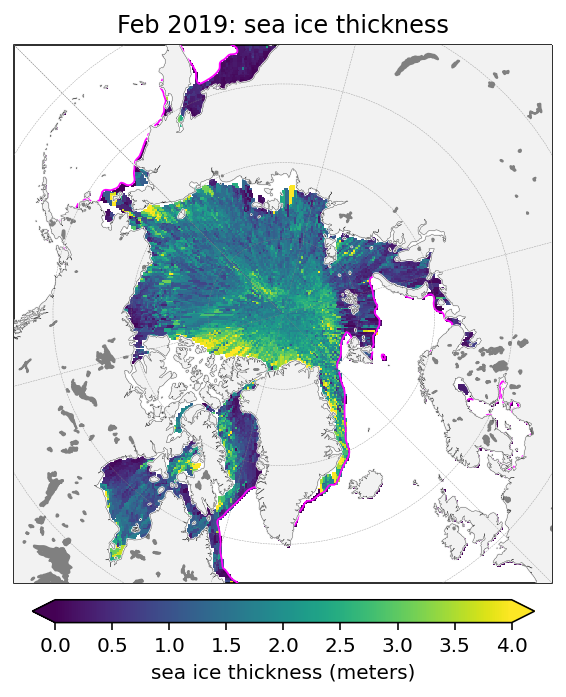

In [6]:
plotOneMonth(dataset, dataVar = 'ice_thickness_filled', month = 'Feb 2019', minval = 0, maxval  = 4)

## Define plotting function
This function can also be accessed from the utils.py file, stored in the google bucket for this book.
 - This function is modified from the plotOneMonth function above
 - Winter is defined as the months Nov, Dec, Jan, Feb, Mar, Apr

In [7]:
def plotWinterMaps(dataset, dataVar, winter, minval, maxval, cbarTicks = None, title = "", cmap = 'viridis'):
    """Plot maps of the arctic on North Pole Stereo projection with several months of data overlayed, along with the sea ice edge for each month. 
   
    Args:
        dataset (xr Dataset): dataset from google bucket
        dataVar (str): variable of interest
        winter (list): list of pandas Timestamp objects generated by getWinterDateRange(startYear, endYear)
        minval, maxval (int): minimum and maximum values for the data variable 
        cbarTicks (list or np array of length 2): ticks to use on colorbar (default to [minval + 1, maxval +1])
        title (str, optional): title of subplots (default to empty string)
        cmap (str, optional): color map (default to viridis)

    Returns:
        Figure displayed in notebook 

    """
    #format time for plotting 
    timeFormatted = list(pd.to_datetime(winter).strftime('%B %Y'))
    
    #define projection and transform
    proj = ccrs.NorthPolarStereo(central_longitude = -45)
    transform = ccrs.PlateCarree()
    
    #define arguments if not inputted 
    cbarTicks = np.arange(minval, maxval + 1, 1) if cbarTicks is None else cbarTicks
    
    #plot the data
    im = dataset[dataVar].where(dataset['seaice_conc_monthly_cdr'] > 0.5).sel(time = winter).plot.pcolormesh(x = 'longitude', y = 'latitude', vmin = minval, vmax = maxval, cmap = cmap,
        extend='both', levels=20, transform = transform, col='time', add_colorbar = True, zorder = 2, figsize = (8,8), col_wrap = 3,
        cbar_kwargs = {'ticks': cbarTicks, 'label': dataset[dataVar].attrs['long_name'] + ' (' + dataset[dataVar].attrs['units'] + ')', 'orientation': 'horizontal', 'shrink': 0.4, 'pad': 0.03},
        subplot_kws = {'projection': proj})
    
    #add a title
    plt.suptitle(title + ': ' + dataset[dataVar].attrs['long_name'], fontsize = 20, y = 0.99, fontweight = 'medium')

    i = 0 #indexer to go through timeFormatted and winter arrays and assign the correct data to each month
    for ax in im.axes.flat:
        ax.coastlines(linewidth=0.25, color = 'black', zorder = 10) #add coastlines 
        ax.add_feature(cfeature.LAND, color ='0.95', zorder = 5) #add land 
        ax.add_feature(cfeature.LAKES, color = 'grey', zorder = 5) #add lakes 
        ax.gridlines(draw_labels = False, linewidth = 0.25, color = 'gray', alpha = 0.75, linestyle='--', zorder = 6) #add gridlines
        ax.set_extent([-179, 179, 50, 90], crs = transform) #zoom in so map only displays the Arctic

        #plot sea ice concentration 
        SICarray = dataset['seaice_conc_monthly_cdr'].sel(time = winter[i]).where(dataset['region_mask']!=21) #dont plot contour along coastlines
        lonGreater = ma.masked_greater(SICarray.longitude.values, -0.01)
        lonLesser = ma.masked_less(SICarray.longitude.values, 0)
        latGreater = ma.MaskedArray(SICarray.latitude.values, mask = lonGreater.mask)
        latLesser = ma.MaskedArray(SICarray.latitude.values, mask = lonLesser.mask)
        dataGreater = ma.MaskedArray(SICarray.values, mask = lonGreater.mask)
        dataLesser = ma.MaskedArray(SICarray.values, mask = lonLesser.mask)
        im2a = ax.contour(lonGreater, latGreater, dataGreater, levels = [0.5], transform = transform, colors = 'magenta', linewidths = 0.8, zorder=5, alpha=1)
        im2b = ax.contour(lonLesser, latLesser, dataLesser, levels = [0.5], transform = transform, colors = 'magenta', linewidths = 0.8, zorder=5, alpha=1)
    
        #set title of each plot to formatted date 
        ax.set_title(timeFormatted[i])
        
        #update indexer 
        i += 1
    
    #display figure in notebook 
    plt.show()

## Plot maps for different data variables
Here, we will call the winter plotting function on some of the variables in the dataset using different arguments for minimum & maximum values and colormap to allow for visualization of the data. 

### Define winter season
These variables will be used for plotting

In [8]:
#Winter 2018-2019 range and descriptive string
winter_18_19 = utils.getWinterDateRange(2018, 2019)
winter_18_19_str = 'Winter ' + str(2018) + ' - ' + str(2019)

#Winter 2019-2020 range and descriptive string
winter_19_20 = utils.getWinterDateRange(2019, 2020)
winter_19_20_str = 'Winter ' + str(2019) + ' - ' + str(2020)

### ICESat-2 sea ice thickness

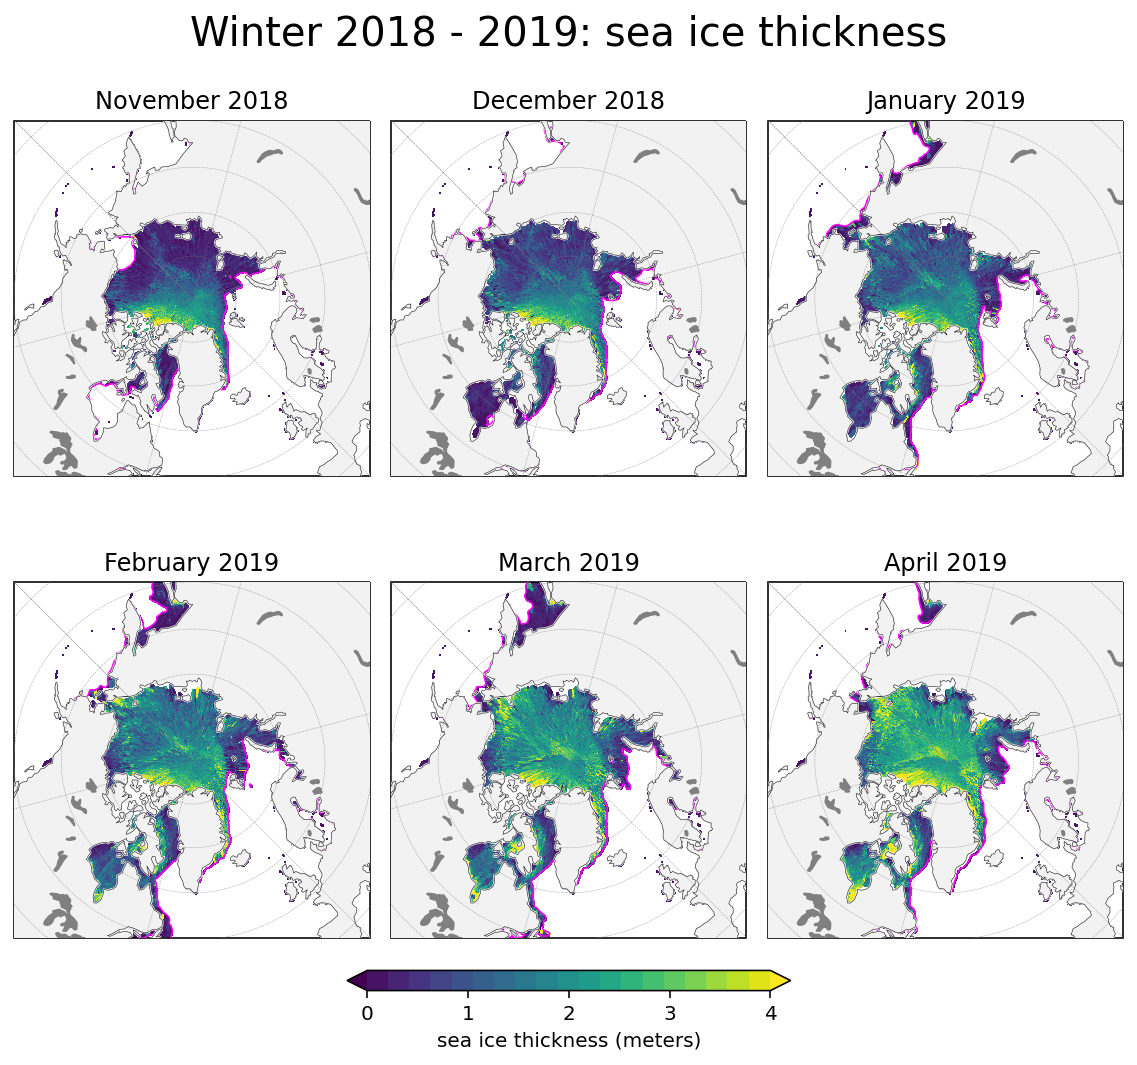

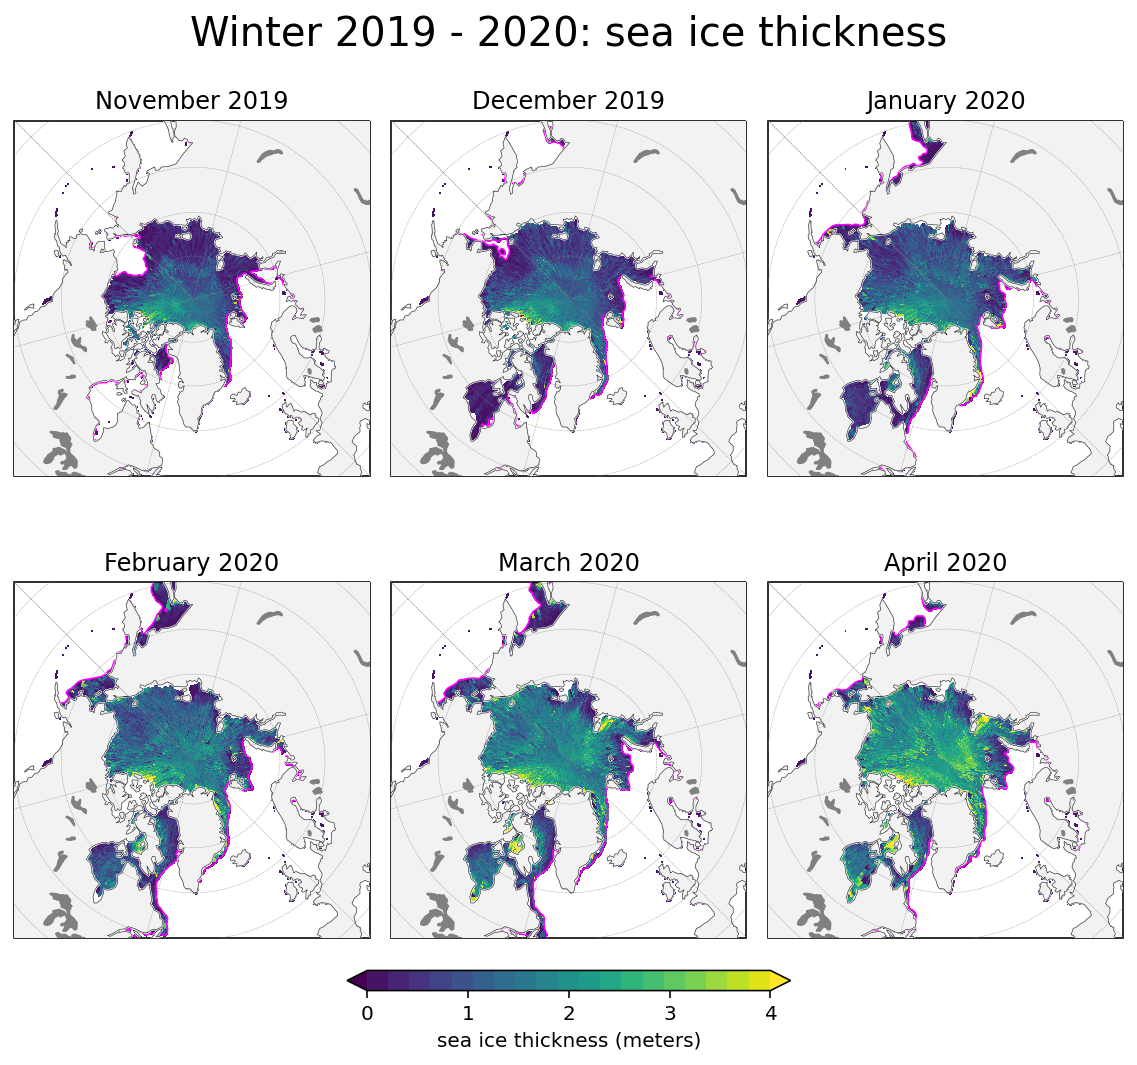

In [9]:
#winter 2018-2019
plotWinterMaps(dataset, dataVar = 'ice_thickness_filled', winter = winter_18_19, 
               minval = 0, maxval = 4, title = winter_18_19_str)

#winter 2019-2020
plotWinterMaps(dataset, dataVar = 'ice_thickness_filled', winter = winter_19_20, 
               minval = 0, maxval = 4, title = winter_19_20_str)

### PIOMAS sea ice thickness 

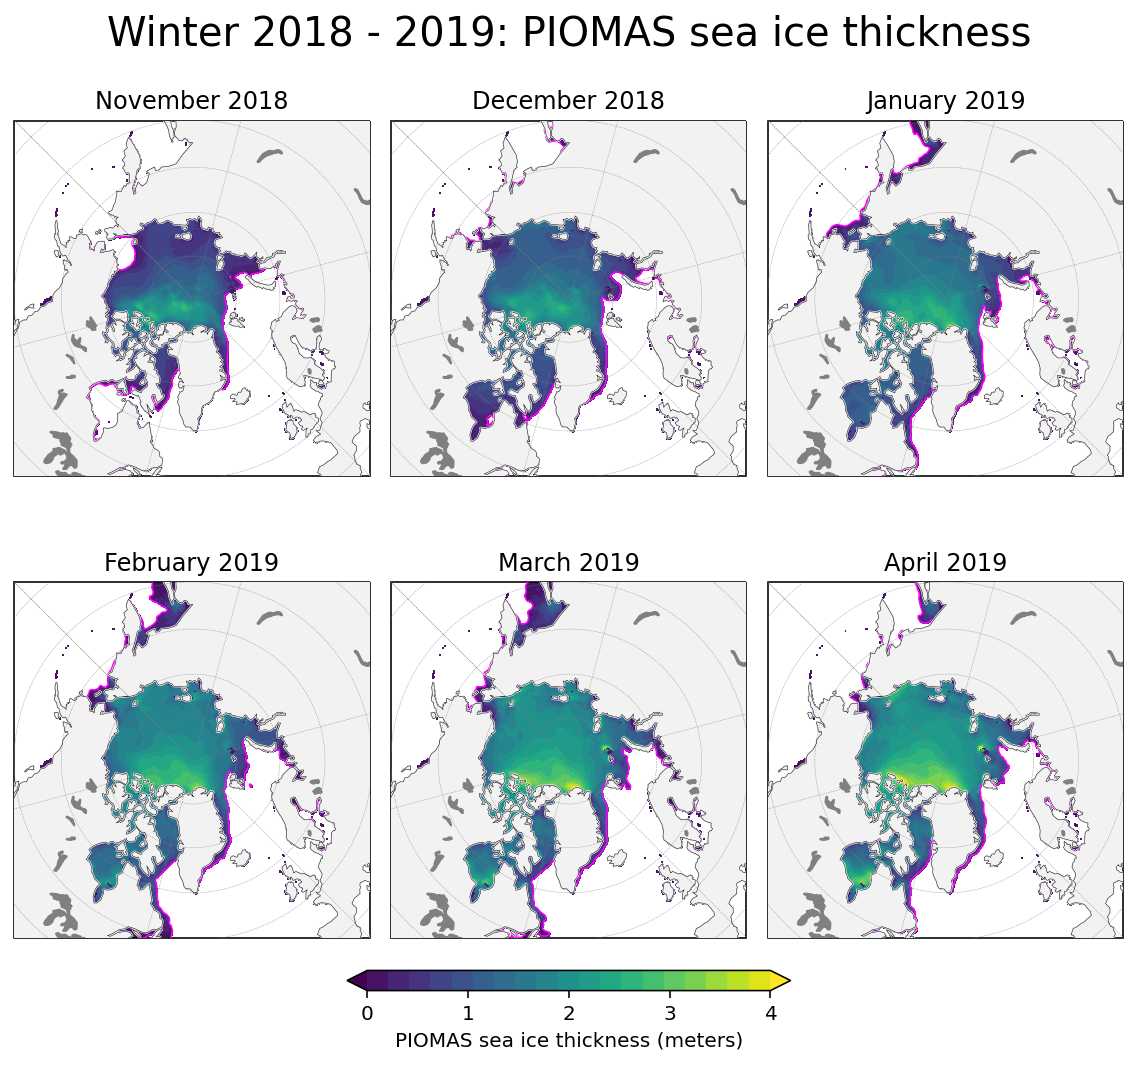

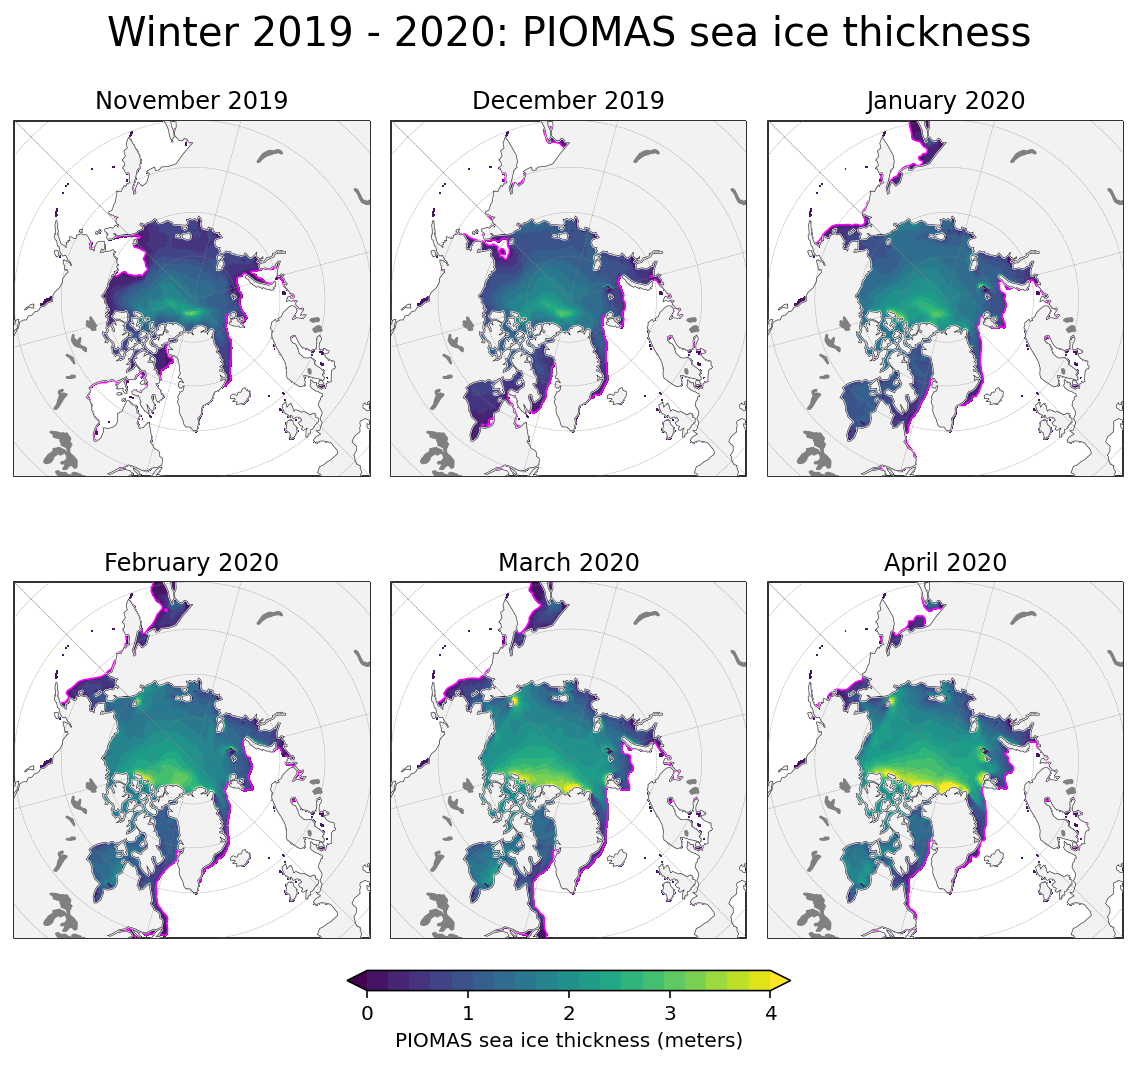

In [10]:
#winter 2018-2019
plotWinterMaps(dataset, dataVar = 'PIOMAS_ice_thickness', winter = winter_18_19, 
               minval = 0, maxval = 4, title = winter_18_19_str)

#winter 2019-2020
plotWinterMaps(dataset, dataVar = 'PIOMAS_ice_thickness', winter = winter_19_20, 
               minval = 0, maxval = 4, title = winter_19_20_str)

### ICESat-2 sea ice thickness uncertainty
This variable describes systematic uncertainty in the sea ice thickness measurement.

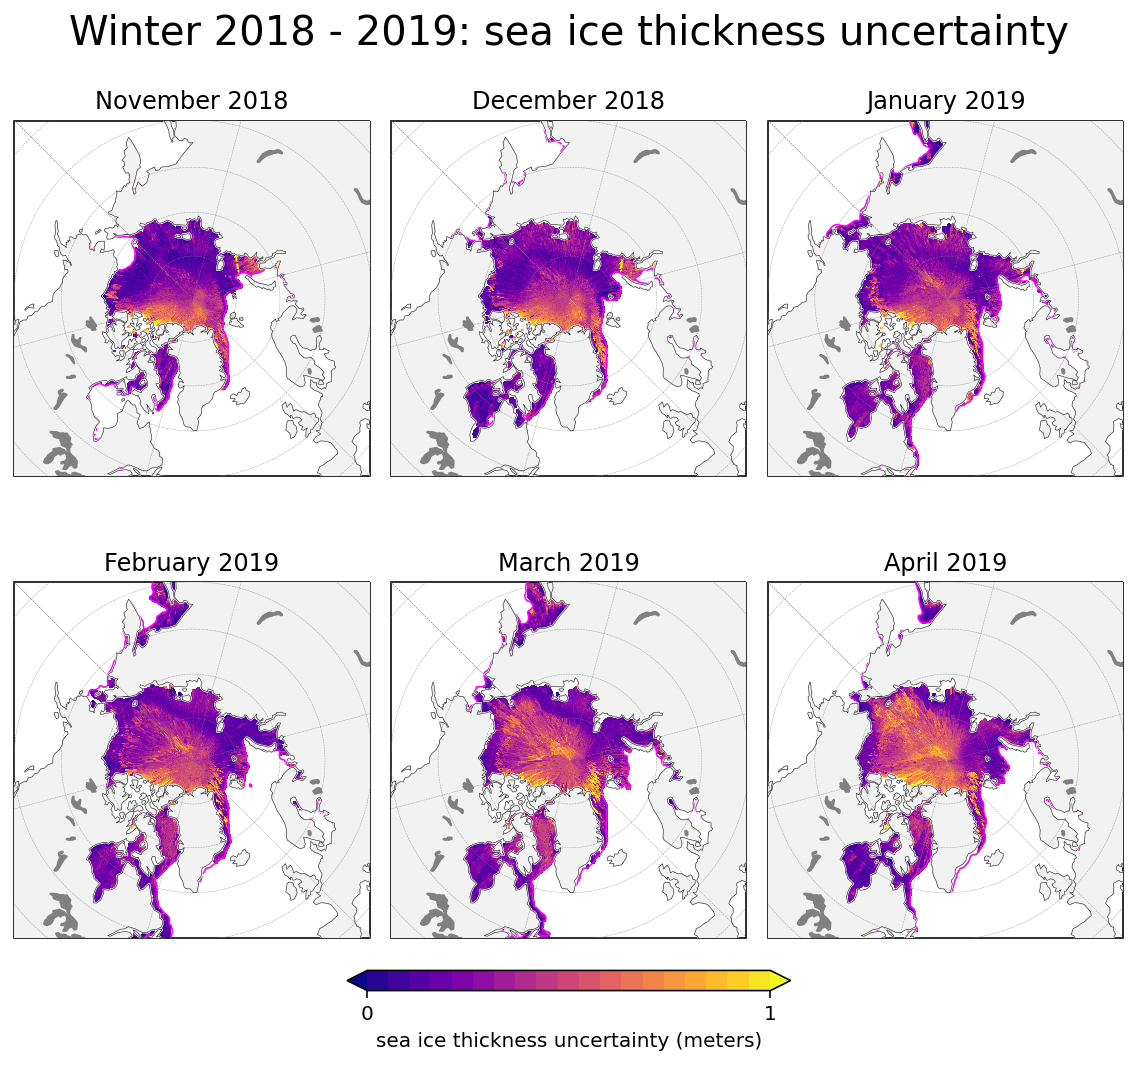

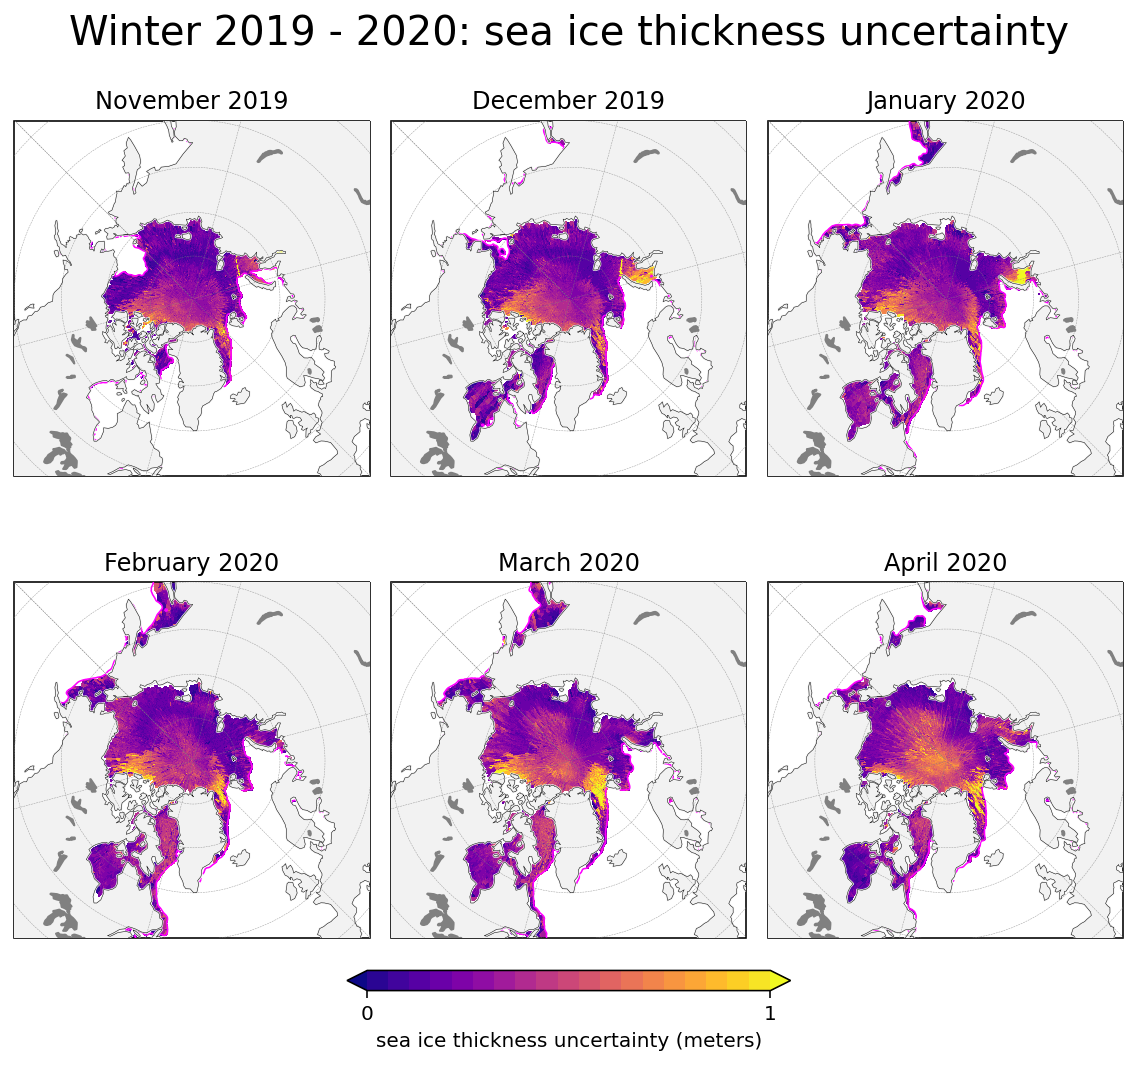

In [11]:
#winter 2018-2019
plotWinterMaps(dataset, dataVar = 'ice_thickness_unc_filled', winter = winter_18_19, 
               minval = 0, maxval = 1, cmap = 'plasma', title = winter_18_19_str)

#winter 2019-2020
plotWinterMaps(dataset, dataVar = 'ice_thickness_unc_filled', winter = winter_19_20, 
               minval = 0, maxval = 1, cmap = 'plasma', title = winter_19_20_str)

### OSI-SAF ice type
Ice type is either multi-year ice (set to 1) or first-year ice (set to 0). 

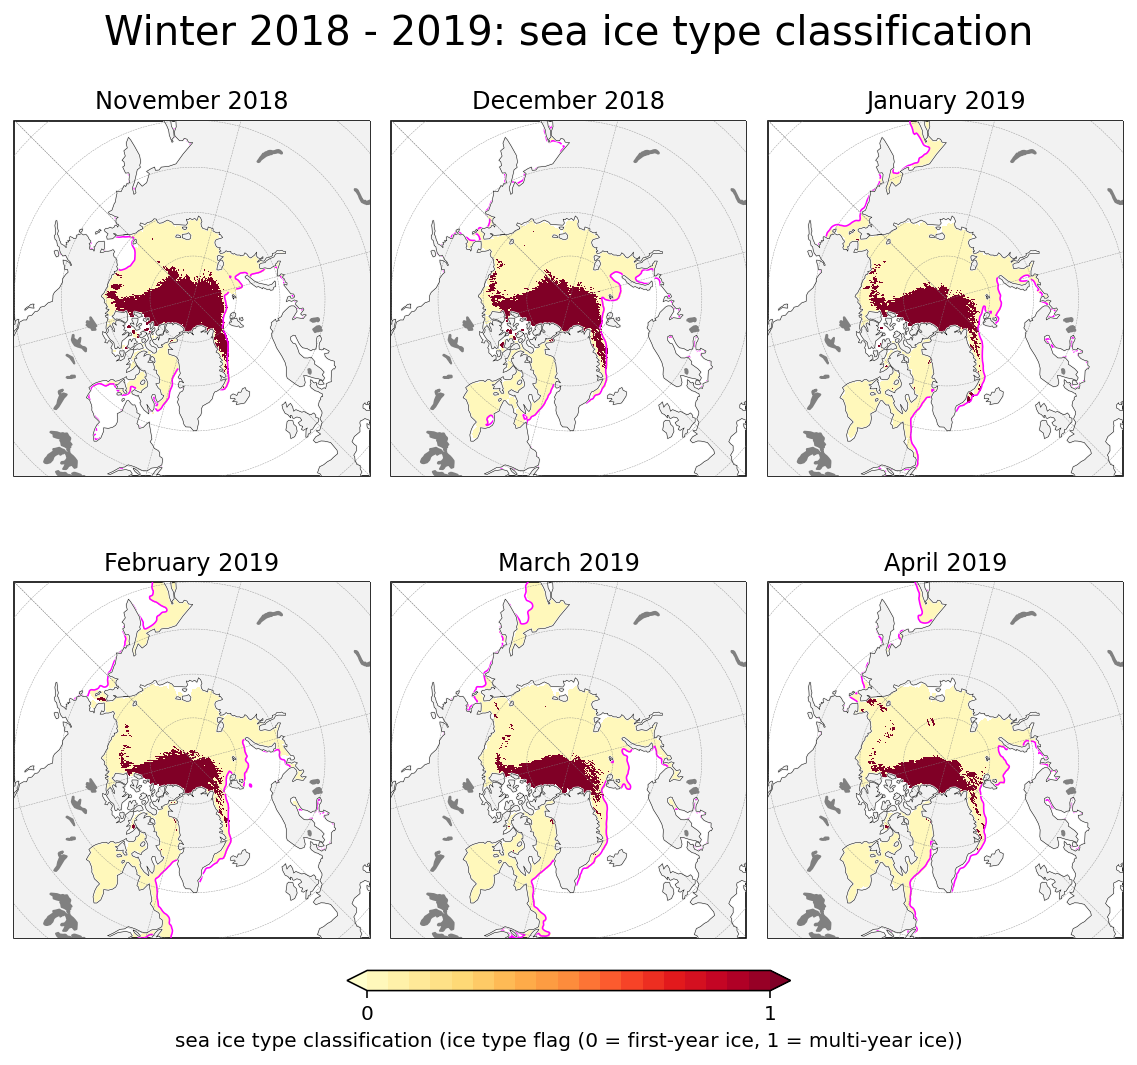

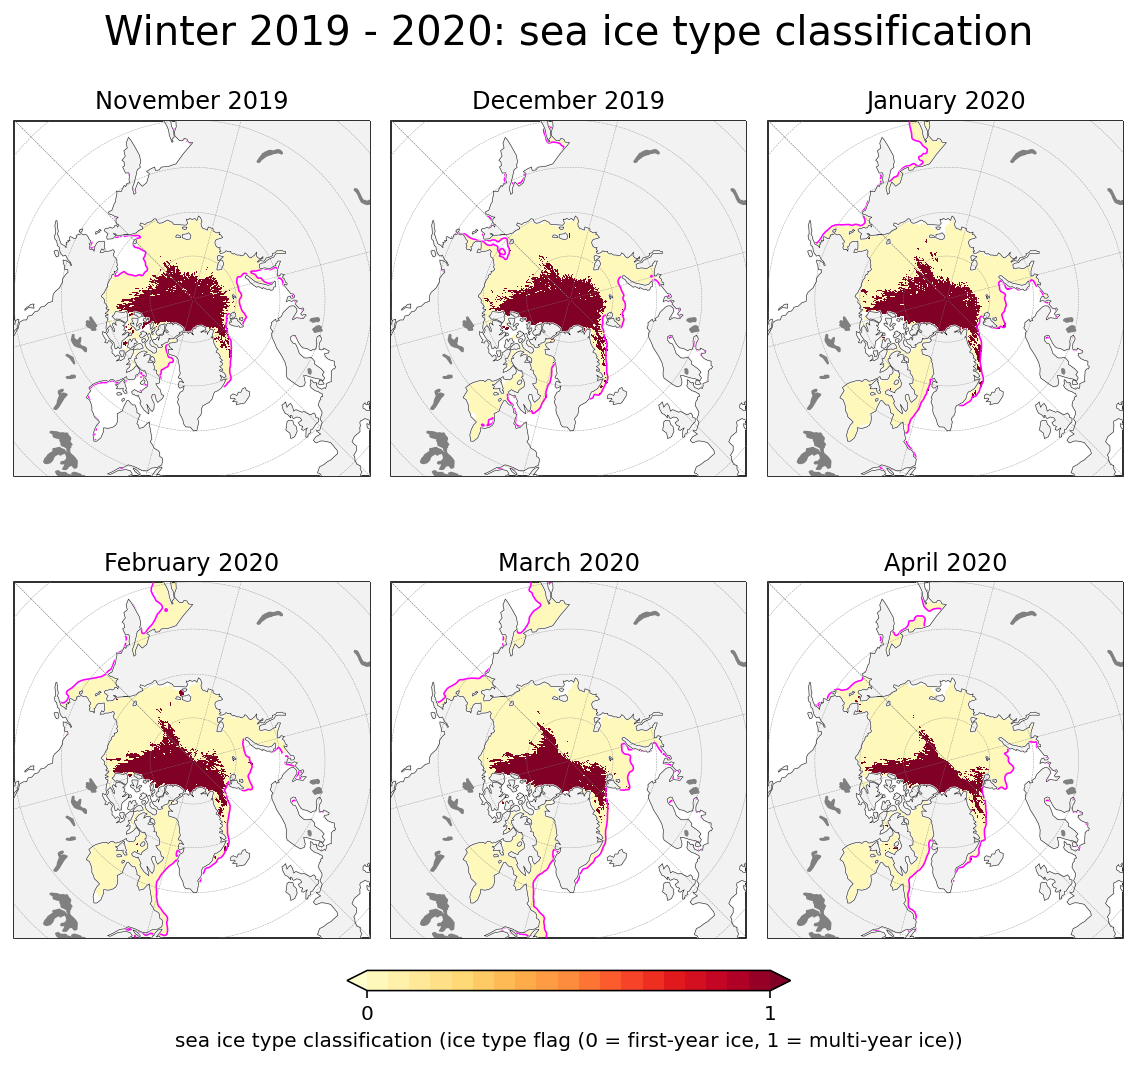

In [12]:
#winter 2018-2019
plotWinterMaps(dataset, dataVar = 'ice_type_filled', winter = winter_18_19, 
               minval = 0, maxval = 1, cmap = 'YlOrRd', title = winter_18_19_str)

#winter 2019-2020
plotWinterMaps(dataset, dataVar = 'ice_type_filled', winter = winter_19_20, 
               minval = 0, maxval = 1, cmap = 'YlOrRd', title = winter_19_20_str)

### ERA5 2-meter temperature 

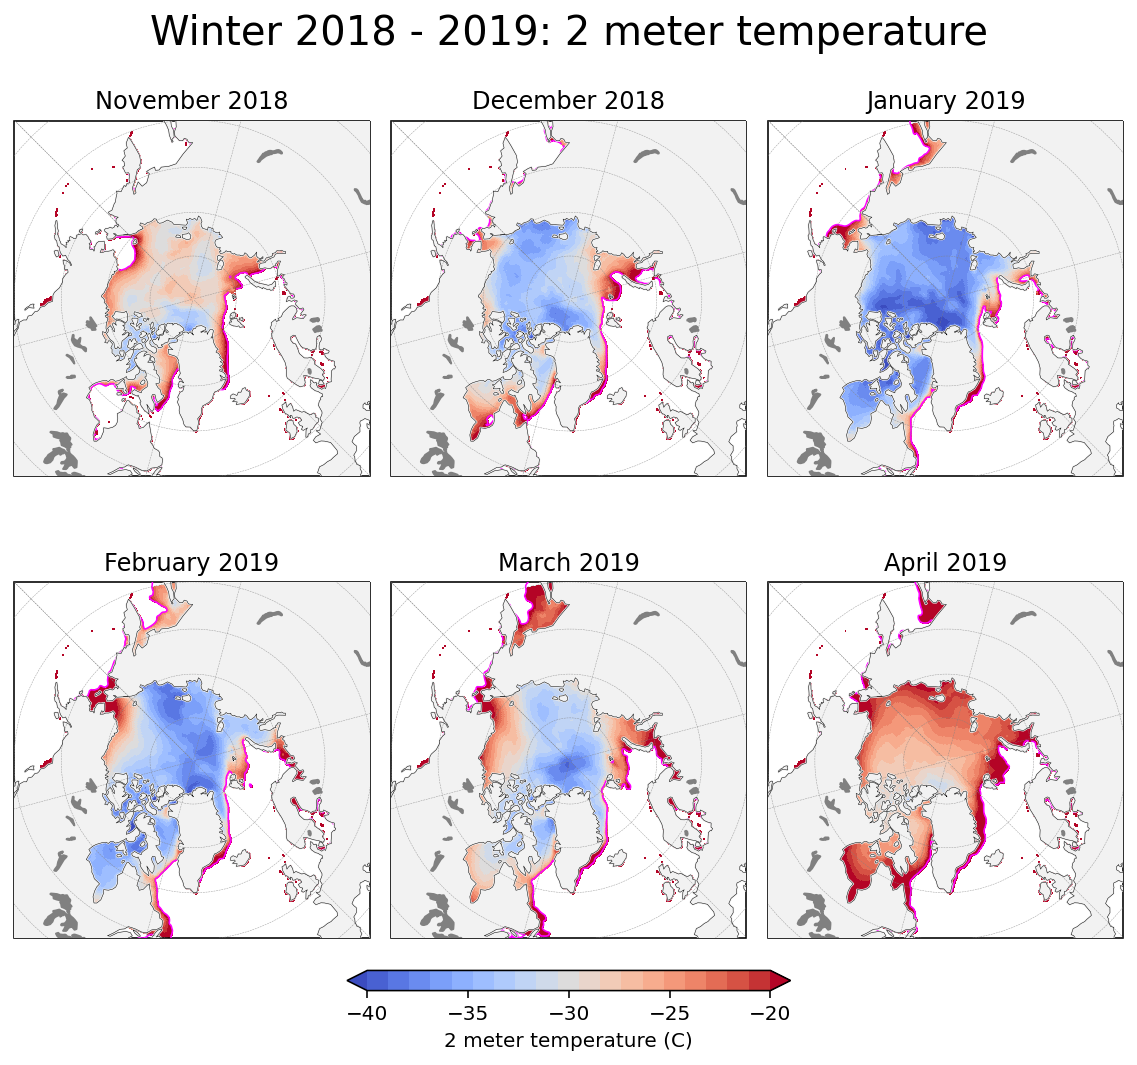

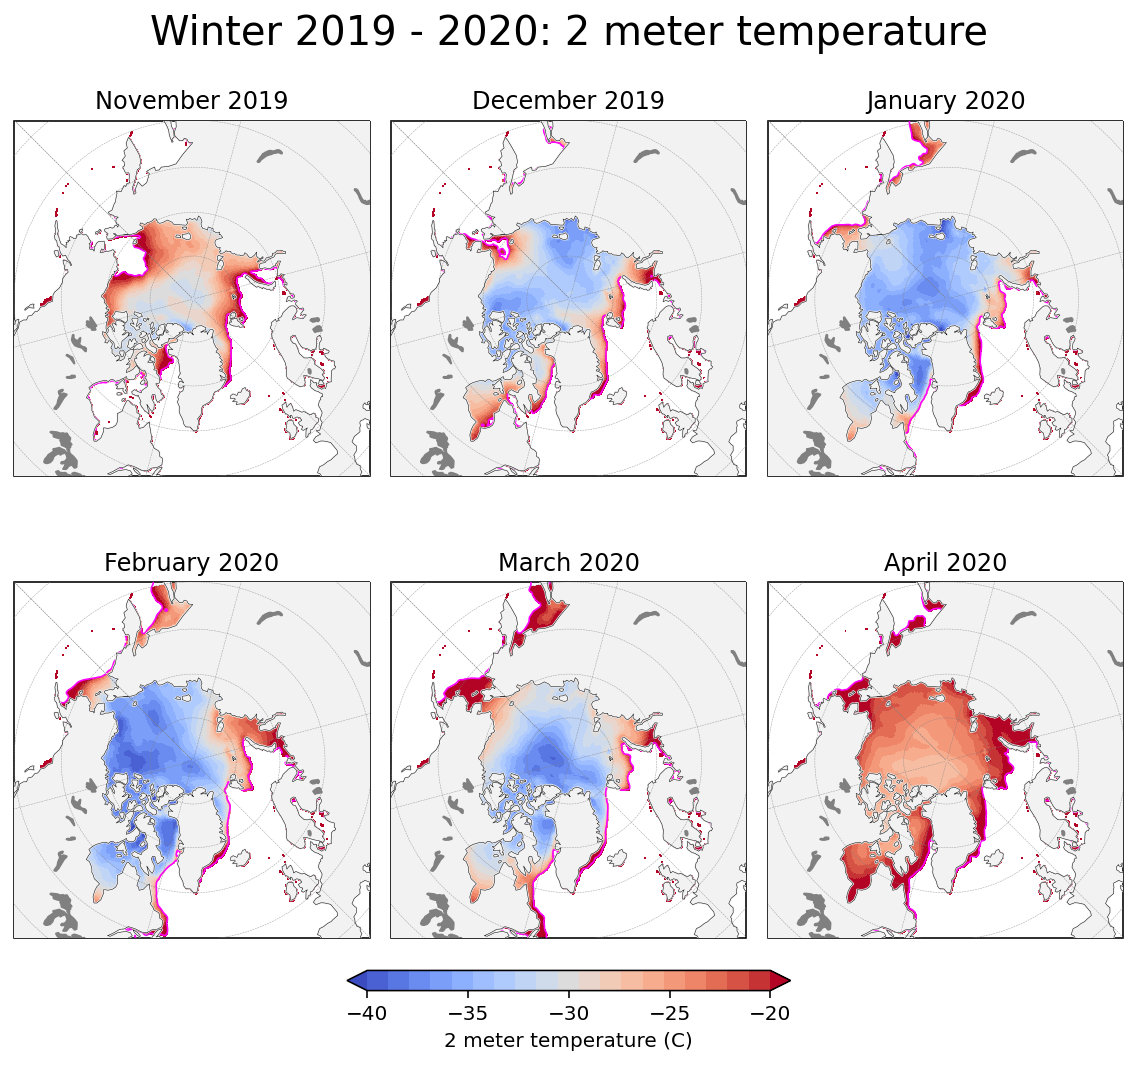

In [13]:
#winter 2018-2019
plotWinterMaps(dataset, dataVar = 't2m', winter = winter_18_19, cbarTicks = np.arange(-40,-20 + 5, 5),
               minval = -40, maxval = -20, cmap = 'coolwarm', title = winter_18_19_str)

#winter 2019-2020
plotWinterMaps(dataset, dataVar = 't2m', winter = winter_19_20, cbarTicks = np.arange(-40,-20 + 5, 5),
               minval = -40, maxval = -20, cmap = 'coolwarm', title = winter_19_20_str)

### ERA5 mean surface downward long-wave radiation flux

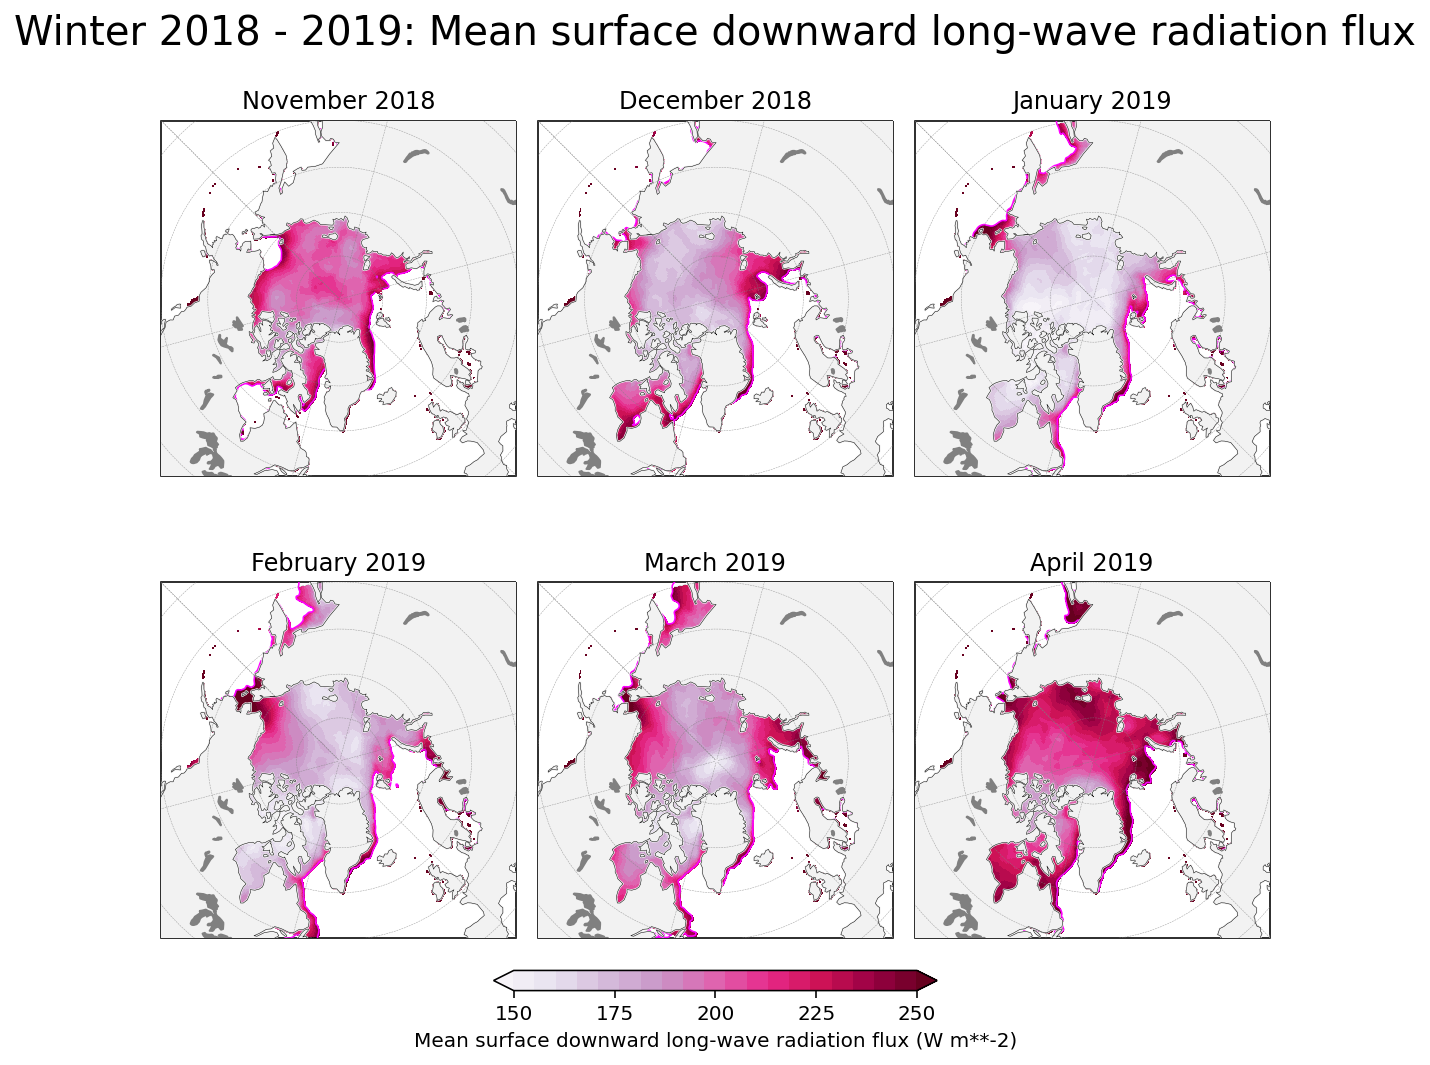

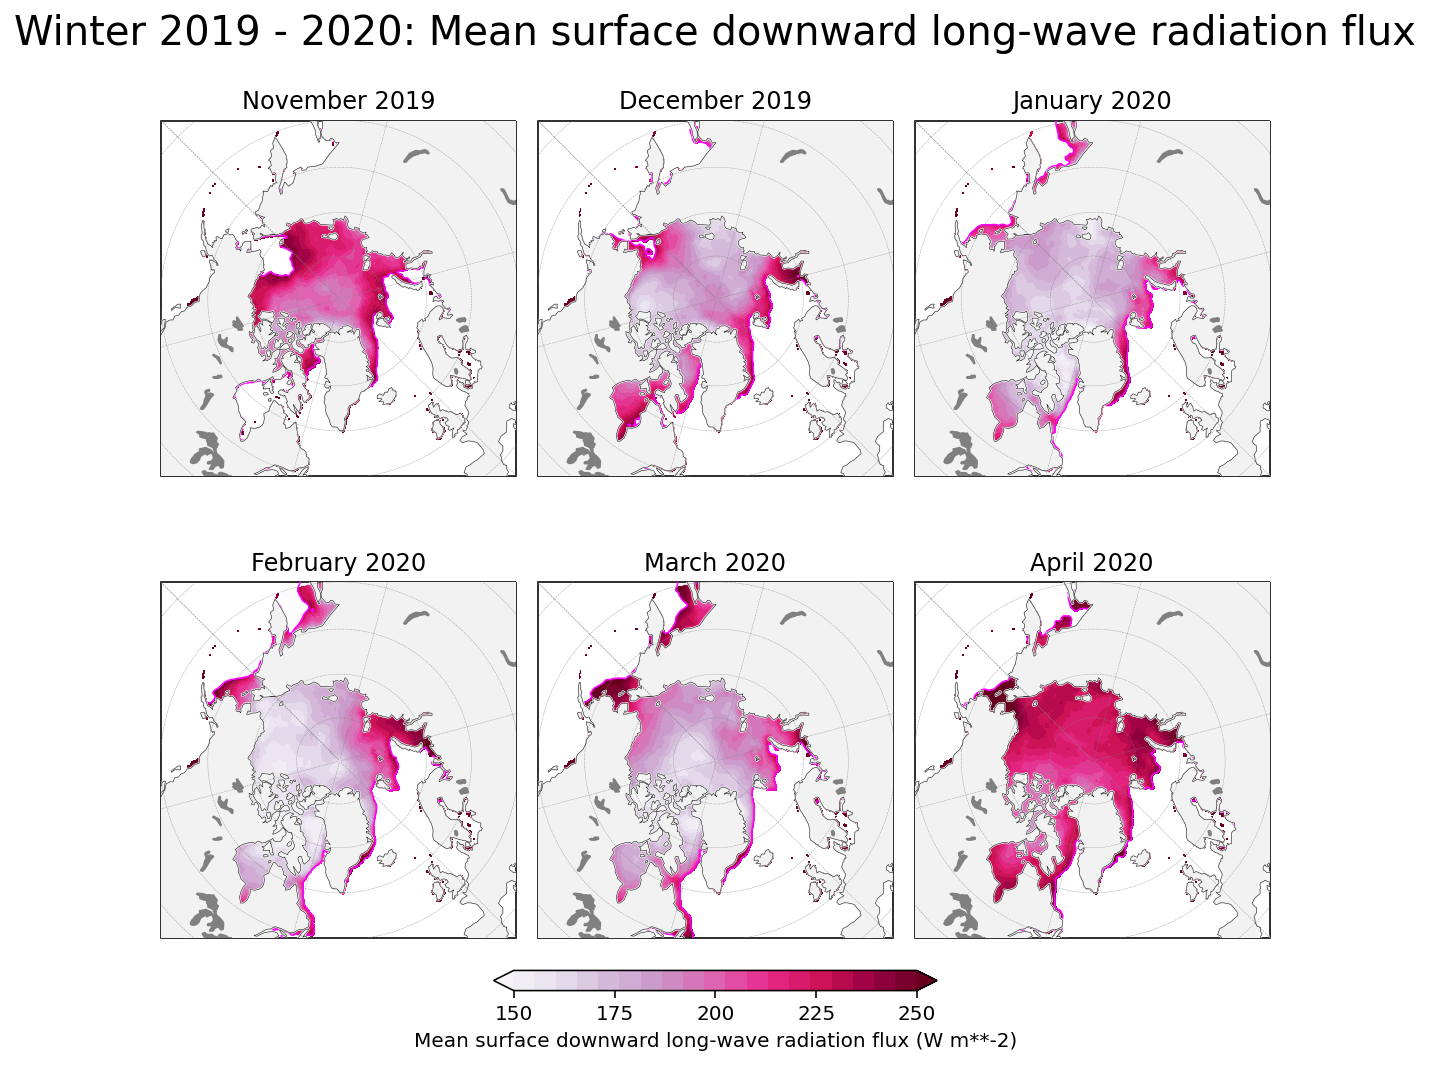

In [14]:
#winter 2018-2019
plotWinterMaps(dataset, dataVar = 'msdwlwrf', winter = winter_18_19, cbarTicks = np.arange(150,250 + 25, 25),
               minval = 150, maxval = 250, cmap = 'PuRd', title = winter_18_19_str)

#winter 2019-2020
plotWinterMaps(dataset, dataVar = 'msdwlwrf', winter = winter_19_20, cbarTicks = np.arange(150,250 + 25, 25),
               minval = 150, maxval = 250, cmap = 'PuRd', title = winter_19_20_str)